<a href="https://colab.research.google.com/github/jefferyxm/llm-hongyi.li-colab/blob/main/GenAI_ML_HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GenAI-ML Homework 6

In this homework, you will train a model to classify 10 characters in "*BanG Dream! It's MyGO!!!!!*" and "*BanG Dream! Ave Mujica*".

**TODO:**


*   Use PyTorch to train a model for image classification
*   Build **Convolutional Neural Network (CNN)** for image classification
*   Implement **data-augmentation** for image data
*   Use **pre-defined model** and **pre-trained weight** and fine-tune it for this task
*   ~~Make you model available for distinguishing Mortis from Mutsumi~~




## Activate GPU

To enable GPU, please follow these steps:

1. Click on "Runtime" (or "執行階段") in the header.
2. Click on "Change runtime type" (or "變更執行階段類型") in the drop menu.
3. Select "T4 GPU" and save. (You can select "A100 GPU" or "V100 GPU" if you have Colab Pro)
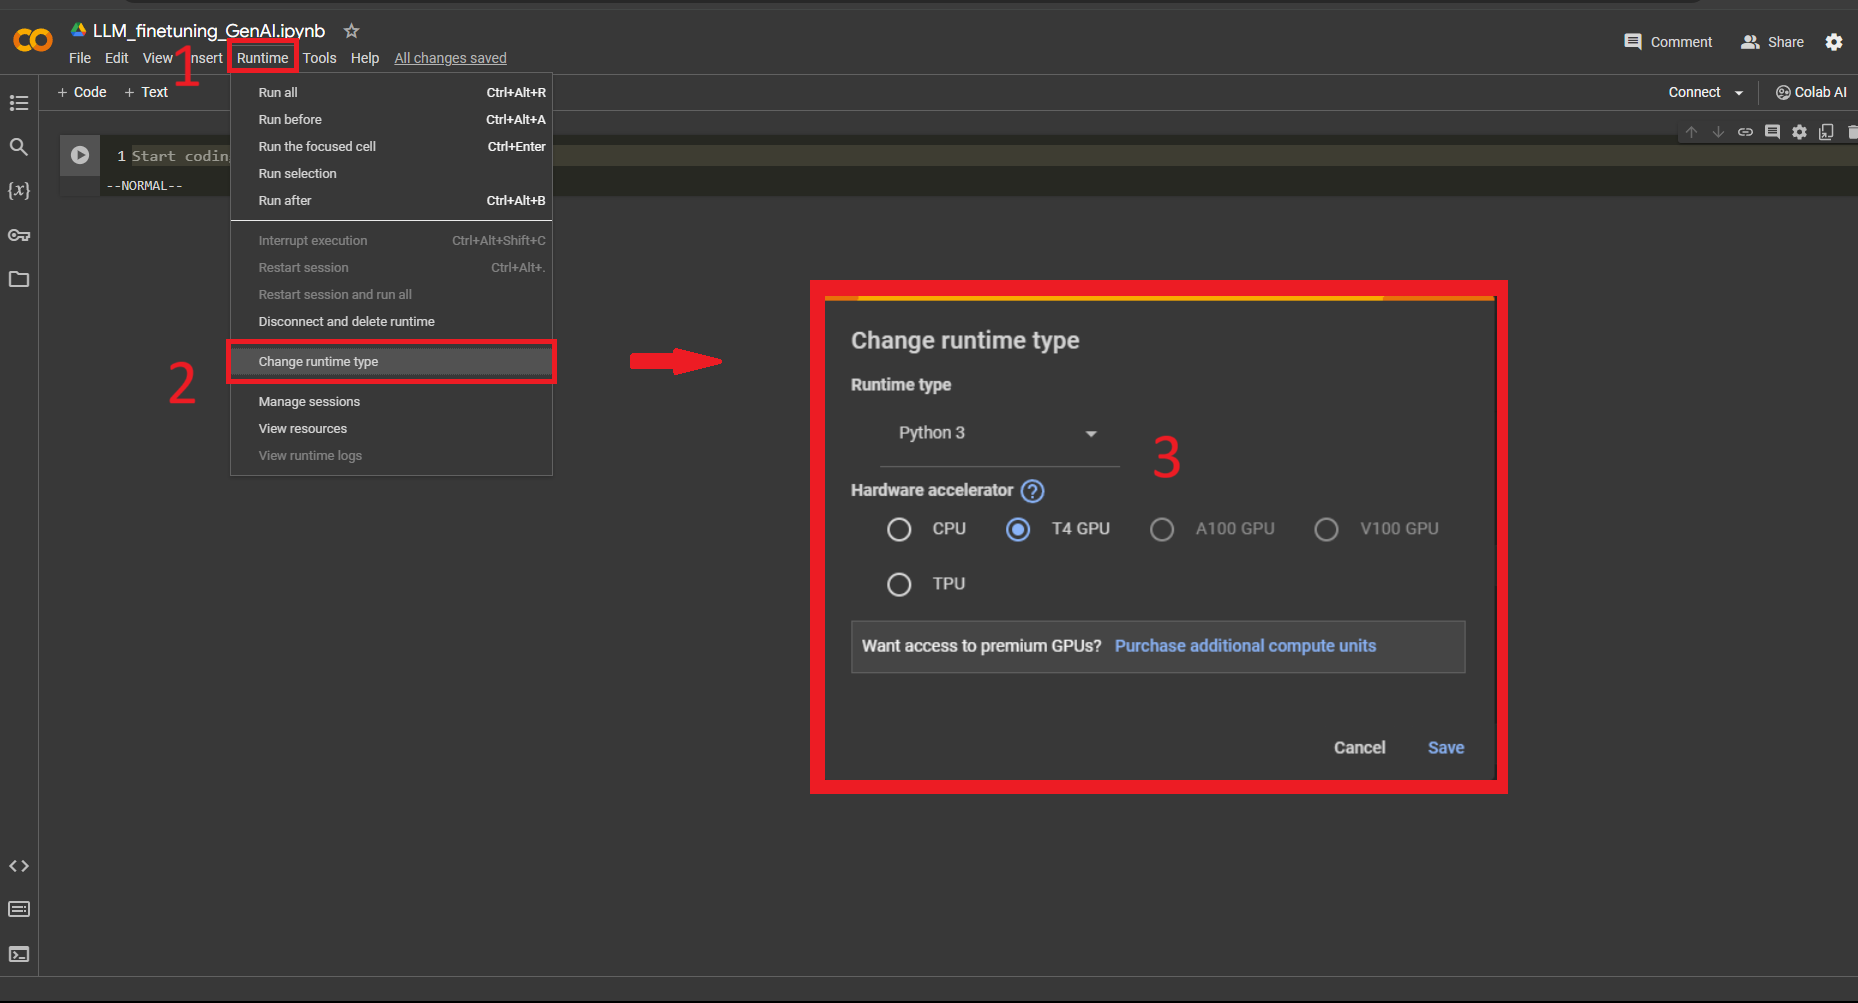

## Mount Google Drive

To mount Google Drive, please follow these steps:

1. Run the next cell.
2. Click on "Connect to Google Drive".
3. Sign in your account.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import Packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import os
import json
from PIL import Image
import numpy as np
import gdown
from tqdm import tqdm
from google.colab import files
import matplotlib.pyplot as plt

# Download dataset

In [ ]:
!git clone https://github.com/steven-lunar/GenAI-ML-HW6.git
%cd ./GenAI-ML-HW6/

In [ ]:
## If the link above is unavaliable or busy, you can try other links here
## Or you just want to download the dataset independently

# !gdown --fuzzy 'https://drive.google.com/file/d/1EayXaoqqEmgt7PUF2EbTdxlmk3vKKcUn/view?usp=sharing'
# !gdown --fuzzy 'https://drive.google.com/file/d/10Y8mKrfhL8gaqICA55ou67A9-8eDOkCb/view?usp=sharing'
# !gdown --fuzzy 'https://drive.google.com/file/d/1pvt0ddY4N4G4nji6i7iBlSjerWZ-YvE8/view?usp=sharing'

In [ ]:
!unzip GenAI-MLhw6_data.zip

# To setup the GPU devices

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

# Setup the transformation for the training and inference phases

Here, we implement preprocessing on the image data we used. In the default setting, the original image size is 150 \* 150 \* 3, we resize it to 128 \* 128 \* 3.

You may change or add new transformations here to implement the data augmentation. Please ensure that the input image size is matched with your model input size.

## Data augmentation

You can use different transformations to "create" more training data for training your models.

(Image ref: https://www.ibm.com/think/topics/data-augmentation)

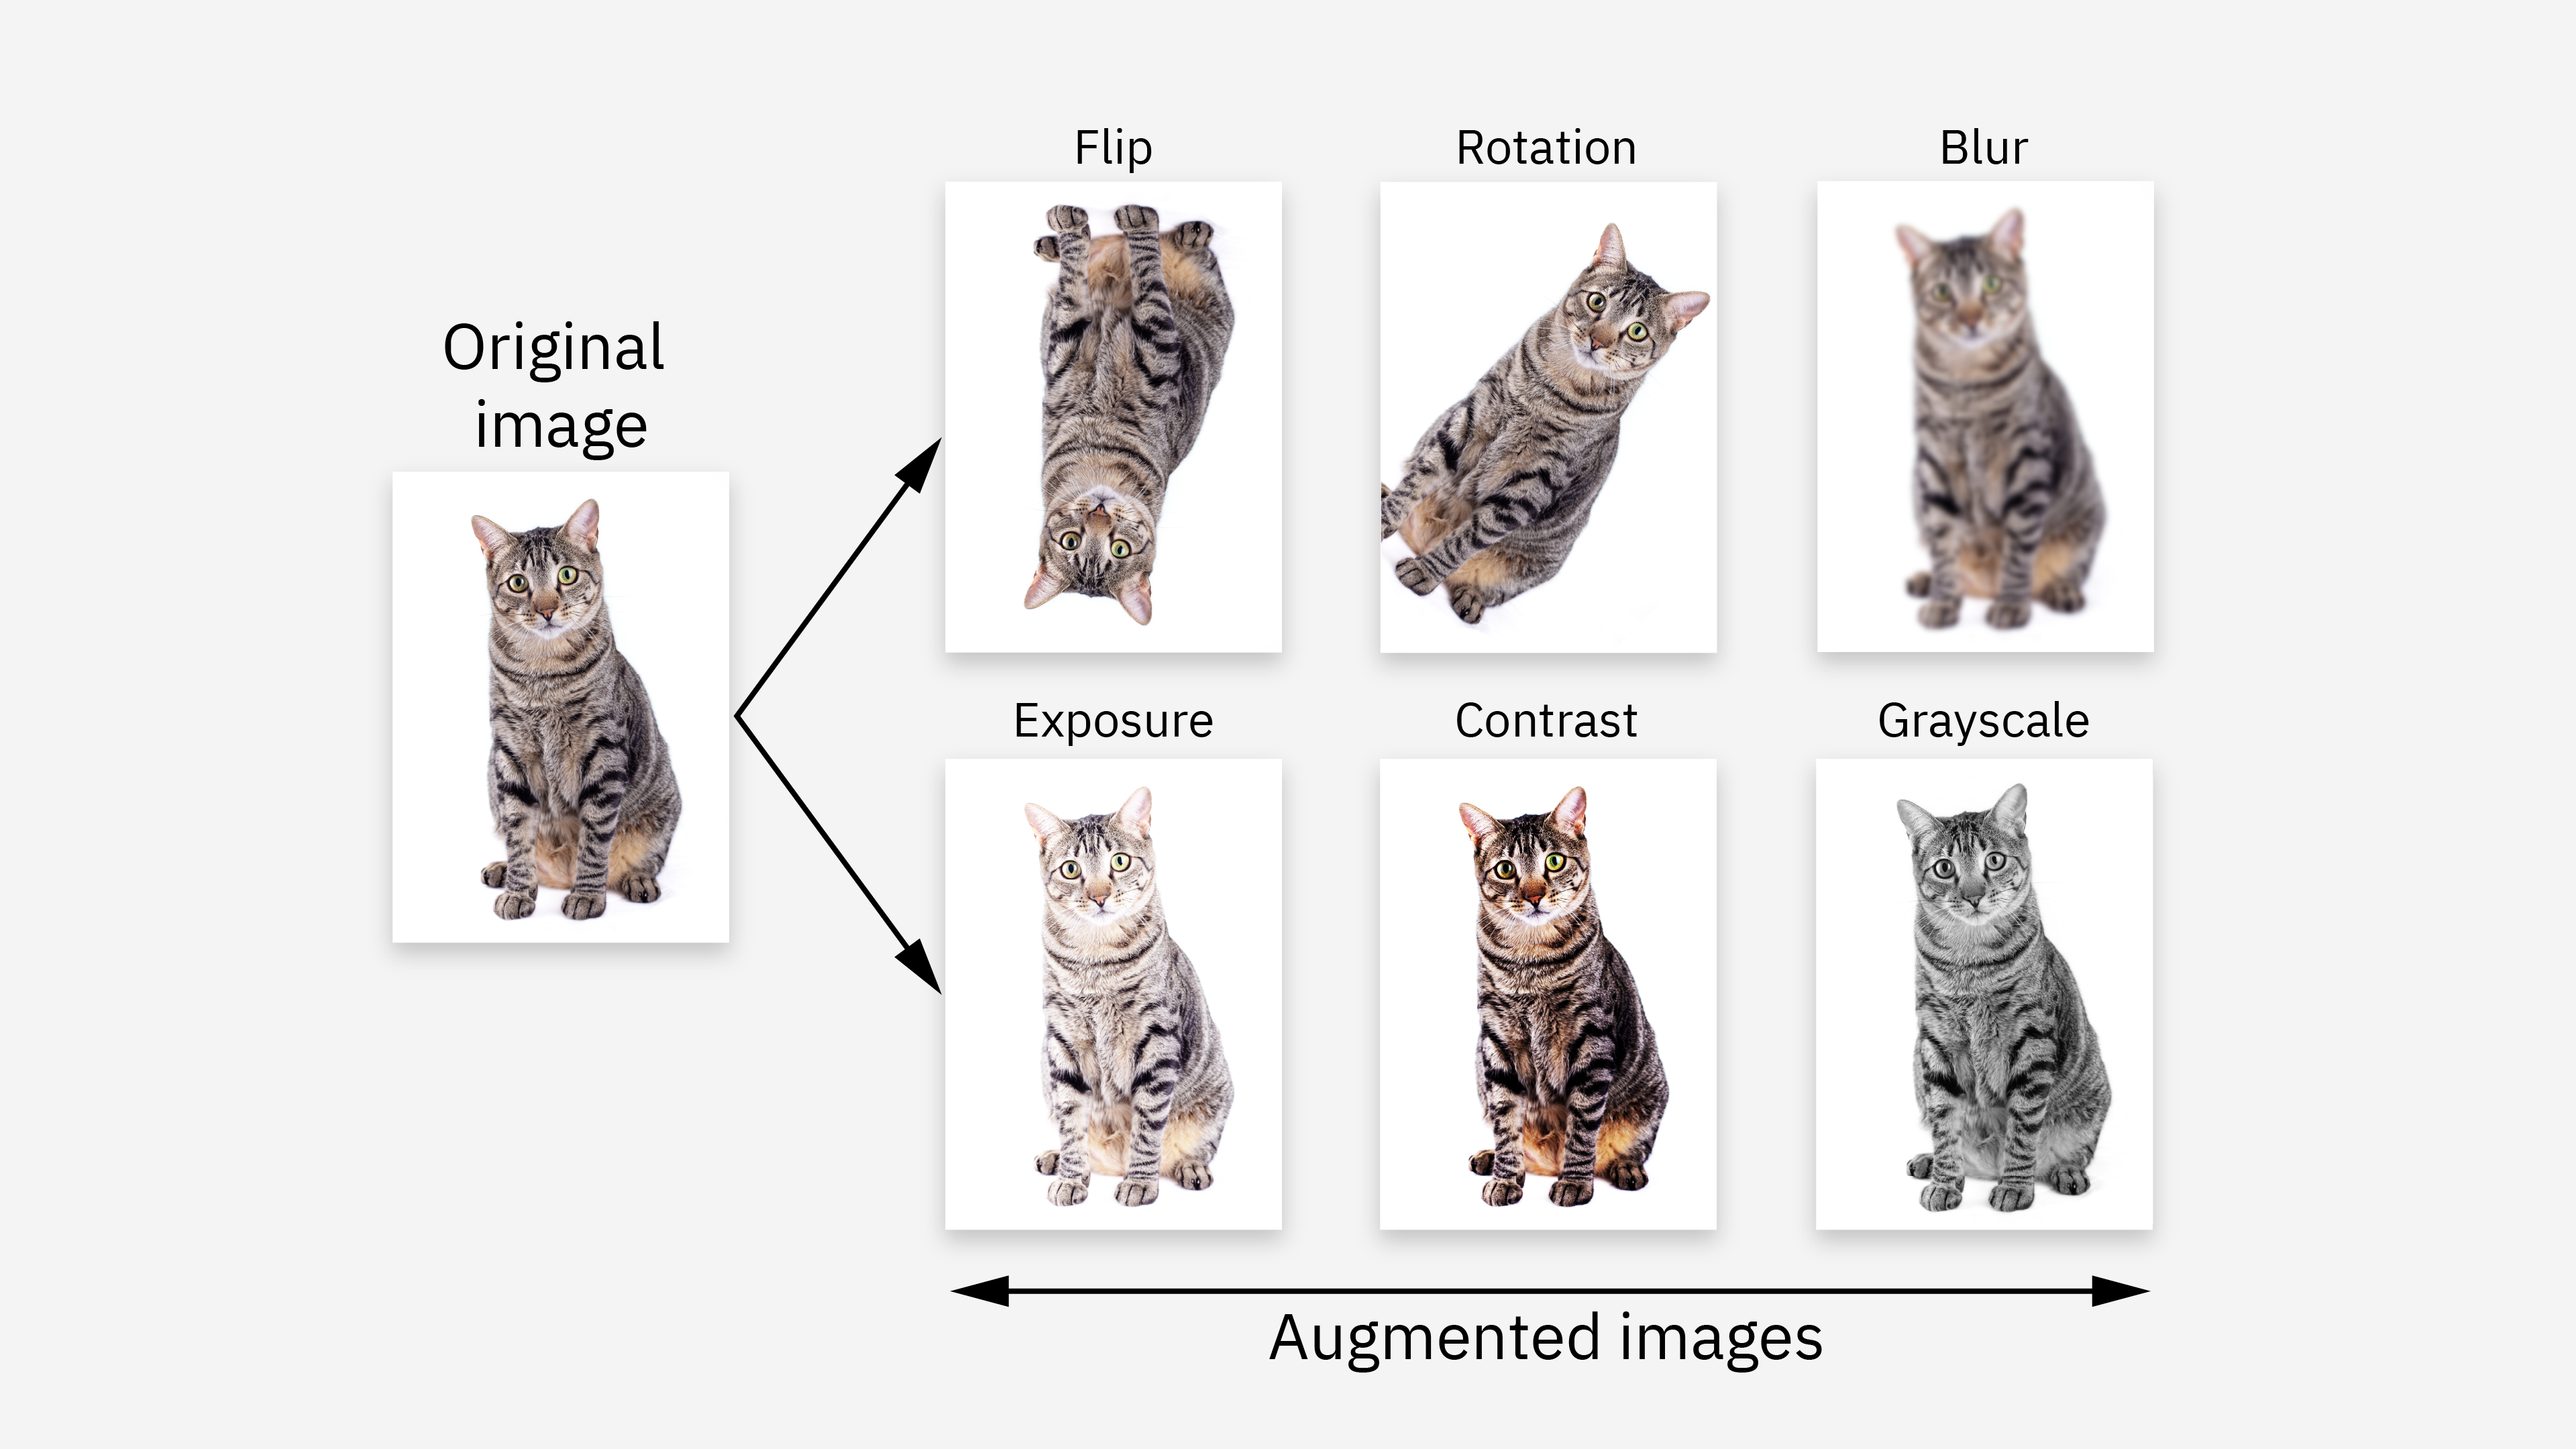

In [ ]:
train_transform = transforms.Compose([
    ## We resize all images to a specific size, 128 * 128 here
    ## You can resize them into other size, yet you may need to modify the architecture of model to fit the input shape
    transforms.Resize((128, 128)),

    ## TODO: Add your personalized transformation here##
    ## You may reference https://docs.pytorch.org/vision/0.11/transforms.html#automatic-augmentation-transforms

    ## Examples:
    ## transforms.RandomVerticalFlip(p=0.5)   # Filp the image vertically
    ## transforms.RandomHorizontalFlip(p=0.5)  # Filp the image horizontally

    ## Transform the numpy array to the torch tensor
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),

    ## TODO: You may using test-time augmentation here (not necessary if you only want to pass all baselines)
    ## You can implement it if you want.
    transforms.ToTensor(),
])

### Example for transformation

We provide some example for transformation here.

In [ ]:
img_path = "./train/0.png"
img = Image.open(img_path).convert("RGB")

transform_list = {
    "Original": transforms.Compose([]),
    "Resize(128,128)": transforms.Resize((128, 128)),
    "RandomCrop(64)": transforms.RandomCrop(64),
    "HorizontalFlip": transforms.RandomHorizontalFlip(p=1.0),
    "VerticalFlip": transforms.RandomVerticalFlip(p=1.0),
    "ColorJitter": transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    "Grayscale": transforms.Grayscale(num_output_channels=3),
    "GaussianBlur": transforms.GaussianBlur(kernel_size=9)
}

n = len(transform_list)
plt.figure(figsize=(12, 3))
for i, (name, t) in enumerate(transform_list.items()):
    transformed_img = t(img)
    plt.subplot(1, n, i + 1)
    plt.imshow(transformed_img)
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Create a table to convert the text label

We don't use the text label directly to train our model. Instead, we first encode the text label into a number representing a specific class (character), and then use them to train models.

Here we have 10 characters in our dataset, the size of this table is 10 of course.

In [ ]:
#############################
## Don't modify this part, or you may get low accuracy on Judgeboi even with good training performance.

label2class = {
    "anon": 0,
    "mutsumi": 1,
    "nyamuchi": 2,
    "rana": 3,
    "sakiko": 4,
    "soyo": 5,
    "taki": 6,
    "tomori": 7,
    "uika": 8,
    "umiri": 9
    ## "mana": 10   ...only appears in few sences...
}

# Define the custom dataset for this task

In [ ]:
##################################
## If you aren't familiar with Dataset in torch, don't modify this part!!!

class MyGOCharacterDataset(Dataset):
    def __init__(self, json_path, images_dir, transform=None):
        """
        Args:
            json_path (str): Path to the json file with the metadata for this dataset (eg. train.json, valid.json, test.json)
            images_dir (str): Path to the images directory (eg. ./train/)
            transform (callable, optional): The transformation set you create (train_transform)
        """
        self.images_dir = images_dir
        self.transform = transform

        ## load metadata
        with open(json_path, 'r', encoding='utf-8') as f:
            self.metadata = json.load(f)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        attr = self.metadata[idx]
        img_path = os.path.join(self.images_dir, attr['filename'])
        idx = attr["id"]
        ## Images are opened with RGB channels, 3 channels
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            ## If there is transformations defined, we implement these transformations on our images
            image = self.transform(image)

        if "test" in self.images_dir:
            ## No label for the testing set, so we don't return labels
            return image, idx
        else:
            label = attr['label']
            label = label2class[label]
            return image, label, idx

###########################################

# Create the subsets for data

We load splited datasets as the training, validation and testing set.

In [ ]:
## You may change the arguments in these dataset depending your environment
## If you follow the sample code in the above steps, you may not modify this part

train_set = MyGOCharacterDataset(
    json_path='./train/train.json',
    images_dir='./train',
    transform=train_transform
)

val_set = MyGOCharacterDataset(
    json_path='./valid/valid.json',
    images_dir='./valid',
    transform=train_transform
)

test_set = MyGOCharacterDataset(
    json_path='./test/test.json',
    images_dir='./test',
    transform=test_transform
)

# Create Dataloader

We create dataloader to load our data, you can adjust the batch size here, it is also a hyperparameter that may make an impact on the performance.

In [ ]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Define the models

We define and build our own image classifier here. When you build your models, you should keep in mind that **a larger model is not always better than a small model**. Therefore, you aren't expected to build a huge model as a image classifier in this homework.

Also, you may pay attention on **the capacity of your google drive**. If there is no enough space for saving trained model weight, errors may occur during your training phase. As a reminder (or a hint), a model with <= 150 MB is large enough for you to pass the boss baseline.

## Linear Model

Here we define a simple linear model as our image classifier.

**This model is so huge (~800 MB), be aware of available space of your google drive!!!**

(Disclaimer: This model is indeed a simple MLP, this model is so huge because the size of image.)


### Let's calculate the number of trainable parameters in this MLP model!!

- First linear layer: 128 \* 128 \* 3 \* 4096 (weight) + 4096 (bias) = 201330688 trainable parameters
- Second linear layer: 4096 * 512 (weight) + 512 (bias) = 2097664 trainable parameters
- Last linear layer: 512 * 10 (weight) + 10 (bias) = 5130 trainable parameters
- Total = 201330688 + 2097664 + 5130 = 203433482 trainable parameters

Each parameter is a 32-bit (4 bytes) floating number, so the model size is:
$$ \frac{203433482 \cdot 4}{1024 \cdot 1024} ≃ 776.04 (\text{MB})$$

What a huge model!!!

In [ ]:
class MyLinearModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        ## TODO: You may modify the linear model here to archieve better performance
        self.simple_linear = nn.Sequential(
            nn.Flatten(),                  # Flatten the image data into a 1D-vector
            nn.Linear(128 * 128 * 3, 4096),       # Fully-connected layer
            nn.ReLU(),                    # Activation function, ReLU here, can change it with other functions
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)          # Using linear layer to map output with number of classes, 10
        )

    def forward(self, x):
        return self.simple_linear(x)

## Convolutional Neural Network (CNN)

A convolutional neural network is a model architecture that often used in image-related task.

A filter is used to extract features in the image. In CNN, we train models to learn these filters.

(Image ref: https://www.dragon1.com/terms/convolutional-neural-networks-definition)

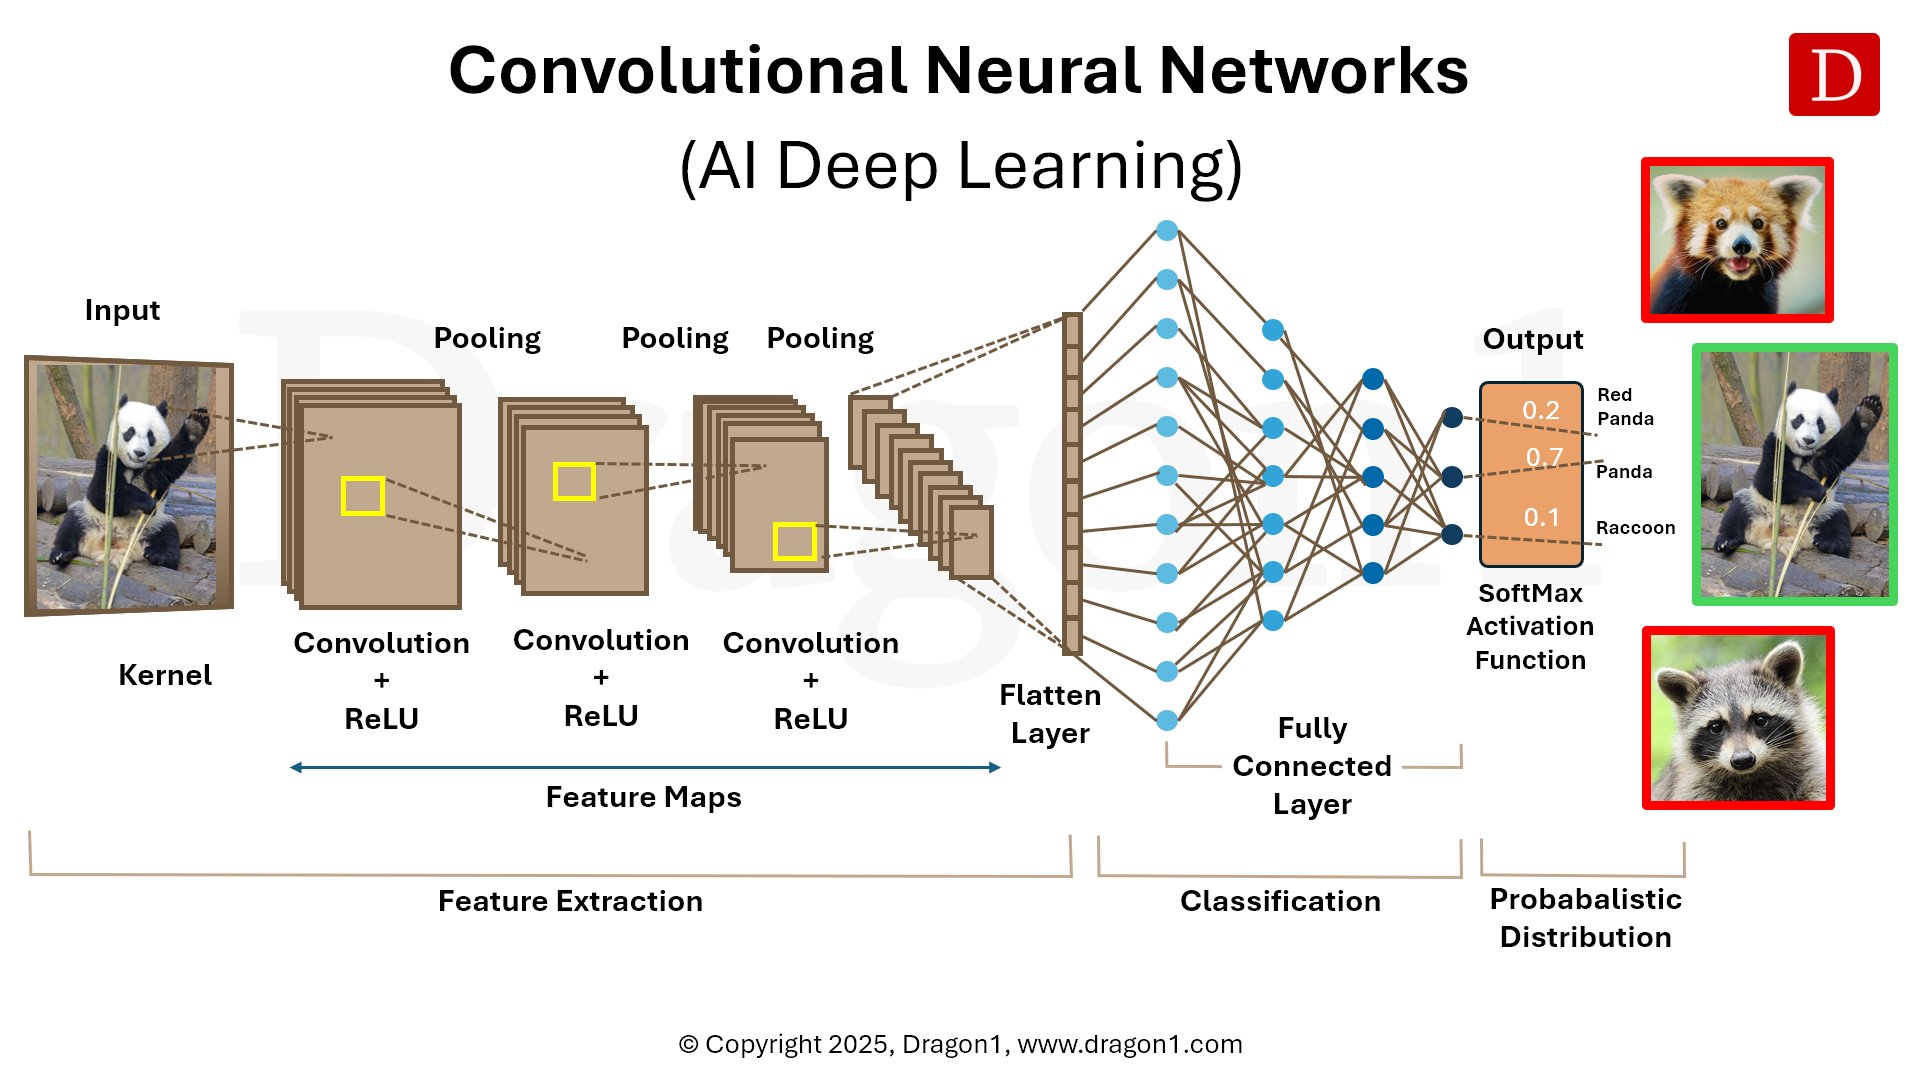

### Let's calculate the number of trainable parameters in this basic CNN model!!

- First convolution layer: 3 \* 32 \* 3 \* 3 = 864  trainable parameters
- Second convolution layer: 32 \* 64 \* 3 \* 3 = 18432  trainable parameters
- First linear layer: 64 \* 2 \* 2 \* 32 + 32 = 8224 trainable parameters
- Second linear layer: 32 \* 10 + 10 = 330 trainable parameters
- Total: 864 + 18432 + 8224 + 330 = 27850 trainable parameters

Each parameter is a 32-bit (4 bytes) floating number, so the model size is:
$$ \frac{27850 \cdot 4}{1024 \cdot 1024} ≃ 0.11 (\text{MB})$$

Much smaller than the previous MLP model, right? However, it has much better performance than the MLP model!

In [ ]:
class MyCNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        ## TODO: Modify the CNN architecture here to get better performance
        ## - Wider
        ## - Deeper
        ## - Not so much downsample to preserve more information in the images (i.e. adjust the kernal size)
        ## - Dropout (nn.Dropout(p), reference: https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)


        ## Pay attention to the input shape, it may not suit your modified model!!
        ## The default input shape here is [batch_size, 128, 128, 3]
        self.simple_CNN = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),      # Convolution layer to capture the features in the image
            nn.BatchNorm2d(32),             # Batch normalization
            nn.ReLU(),                      # Activation function
            nn.MaxPool2d(8, 8, 0),          # Maxpooling to downsample the image and only preserve important information

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(8, 8, 0),

            nn.Flatten(),                   # Flatten the image data into a 1D-vector

            nn.Linear(64 * 2 * 2, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )


        ## TODO: You may use the pre-defined model in this task
        ## You may choose the pre-defined model for yourself
        ## Useful pre-defined model list: https://docs.pytorch.org/vision/main/models.html
        ## Maybe pre-trained weight?

        ## Example:
        ## self.resnet18 = torchvision.models.resnet18(pretrained=False)

        ## You still need to modify the forward() function below to use these pre-defined models on the image
        ## Remember to check the input and output shape of these pre-defined models!

    def forward(self, x):
        return self.simple_CNN(x)

# Determine the saving directory

You can determine the directory to save your model weight and prediction files.

In [ ]:
## You can change the directory for saving the model weight
save_dir = "./linear/"
os.makedirs(save_dir, exist_ok=True)  # To create the saving directory

# Fix random seed for reproducibilty

You can fix a random seed to ensure the reproducibility of your experiment. You can also pick another random seed to seek better performance or use multiple models to implement **ensemble** for testing.

In [ ]:
seed = 42   # You may change random seed here
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Training loop

This function define how we train the model with images and their corresponding labels. Again, be sure the capacity of your google drive is enough for saving model weight.

In [ ]:
def train_model():
    ## Determine the number of epoch
    num_epochs=20

    model = MyLinearModel().to(device)        ## Initialize the model
    criterion = nn.CrossEntropyLoss()   ## Crossentropy loss function for classification task

    ## We use Adam as our optimizer here, you may change another optimizer
    ## Also, you can change the hyperparameters here, like the learning rate and the decay weight
    optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)

    ## For storing the best accuracy on the validation set so far
    best_val_acc = 0

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    for epoch in range(num_epochs):
        model.train()       # Set model to the training phase, i.e., be able to optimize the weight in the model

        train_loss = 0
        train_correct = 0

        print("="*20 + f"Epoch {epoch + 1}" + "="*20)
        for images, labels, idx in tqdm(train_loader):              # Iterating the training set with dataloader
            images, labels = images.to(device), labels.to(device)   # Put the training data (images and labels) to GPU
            optimizer.zero_grad()                                   # Clear the gradient computed with previous batch
            outputs = model(images)                                 # Put the image into model to get the result
            loss = criterion(outputs, labels)                       # Compute cross-entropy loss between the label and the model output
            loss.backward()                                         # Back propogation
            optimizer.step()                                        # Optimize the model weight

            train_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()

        ## Compute the training loss and the accuracy for this epoch
        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / len(train_set)
        print(f"Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.2%}")


        ## Validation phase

        val_correct = 0
        val_loss = 0
        model.eval()    # Set the model in evaluate phase
        with torch.no_grad():   # Set the gradient to zero
            for images, labels, idx in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / len(val_set)
        print(f"Valid Loss={avg_val_loss:.4f}, Valid Acc={val_acc:.2%}")


        ## Save the model weight with the best accuracy on the validation set
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_path = os.path.join(save_dir, 'best_model.pth')
            torch.save(model.state_dict(), save_path)
            print("Model saved (best validation acc.)")

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs, label='Validation Acc')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    import glob
    for path in glob.glob(f"{save_dir}/*.pth"):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print("Your model size:")
        print(f"{path}: {size_mb:.2f} MB")

# Training

It may take about a few minutes to half an hour. If your training process is extremely slow, please check whether the GPU is activated or not.



In [ ]:
train_model()   # Training

# Inference function

In this function, we load the model weight we just trained and use it as an image classifier to classify images into different characters.

After running this function, a json file containing predictions from your model should be produced and downloaded.

You json file must be like such format:

[
  
  {"id": 1878, "pred": 0},
  {"id": 1879, "pred": 1},
  ... (500 entries)

]

In [ ]:
def inference():
    ## Load the model weight to inference on the testing set
    model = MyLinearModel().to(device)
    ## Be sure that the model weight you loaded has the same architecture of the model you assign!
    ## That is, you cannot load a weight of "MyCNNModel" into a "MyLinearModel"
    model.load_state_dict(torch.load(os.path.join(save_dir, 'best_model.pth')), strict=False)

    model.eval()
    results = []
    idx_list = []

    with torch.no_grad():
        for images, idx in tqdm(test_loader):
            images = images.to(device)
            outputs = model(images)  # shape: [batch_size, num_classes]
            preds = outputs.argmax(dim=1).cpu().tolist()  # Get prediction of model

            results.extend(preds)
            idx_list.extend(idx.cpu().tolist())

    ## Remember to modify STUDENT_ID with your own student id!!!
    STUDENT_ID = 'B14902000'

    ########
    ## This part is for producing the prediction file in json format.
    ## If you aren't familir with json, you may not modify this part.

    final_output = []
    for (idx, result) in zip(idx_list, results):
      out = {
          "id": idx,
          "pred": result
      }
      final_output.append(out)

    ## Saving the prediction
    output_path = os.path.join(save_dir, f'{STUDENT_ID.lower()}.json')
    with open(output_path, "w") as f:
        json.dump(final_output, f, indent=4)

    ## Download the output file
    files.download(output_path)

    ########

# Inferencing

It takes a few seconds to produce the prediction. Again, if the process is extremely slow, you should check whether the GPU is activated or not.

In [ ]:
inference()   # Inferencing

# Complete your homework

Yeah! You successfully trained your own models to make prediction on the dataset. Don't forget to submit your prediction file to "judgeboi" to check your performance.

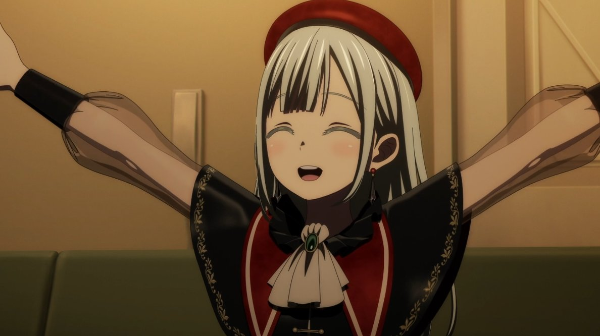